In [1]:
#Importing necessary libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import cv2

In [2]:
#Loading data for training
DATA_DIR='D:/PracticeNN/kagglecatsanddogs_3367a/PetImages'
CATEGORIES=['Dog','Cat']
x_train=[]
y_train=[]
IMG_SIZE=100
count=0
for category in CATEGORIES:
    path=os.path.join(DATA_DIR,category)
    for image in os.listdir(path):
        try:
            img=cv2.imread(os.path.join(path,image),cv2.IMREAD_GRAYSCALE)
            img=cv2.resize(img,(IMG_SIZE,IMG_SIZE))
            x_train.append(img)
            y_train.append(img)
        except Exception as e:
            pass
        count=count+1
        if (count==7001):
            break
    if (count==7001):
        break

In [3]:
#Preparing data for training
x_train=np.array(x_train).reshape(-1,IMG_SIZE*IMG_SIZE)
y_train=np.array(y_train).reshape(-1,IMG_SIZE*IMG_SIZE)
print(x_train[0])
print(len(x_train))

[119 108 140 ...  71  88  75]
6983


In [4]:
#Saving the training data
pickle_out=open('x_train.pickle','wb')
pickle.dump(x_train,pickle_out)
pickle_out.close()
pickle_out=open('y_train.pickle','wb')
pickle.dump(y_train,pickle_out)
pickle_out.close()

In [5]:
#Loading back the data
pickle_in=open('x_train.pickle','rb')
x_train=pickle.load(pickle_in)
pickle_in.close()
y_train=x_train
print(x_train[2])

[118 111  95 ...  92  92  94]


In [6]:
#Constructing the compressor model
input_layer=tf.keras.layers.Input(shape=((int)(IMG_SIZE*IMG_SIZE)),name='Compressor_Input')
hidden_layer_1=tf.keras.layers.Dense(units=(int)(IMG_SIZE*IMG_SIZE/4),name='Dense_Layer_1')(input_layer)
activation_layer_1=tf.keras.layers.LeakyReLU(name='Activation_Layer_1')(hidden_layer_1)
output_layer=tf.keras.layers.Dense(units=(int)(IMG_SIZE*IMG_SIZE/8),name='Dense_Layer_2')(activation_layer_1)
output_layer_activation=tf.keras.layers.LeakyReLU(name='Activation_Layer_2')(output_layer)
compressor=tf.keras.models.Model(input_layer,output_layer_activation,name='Compressor_Model')
compressor.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "Compressor_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Compressor_Input (InputLayer [(None, 10000)]           0         
_________________________________________________________________
Dense_Layer_1 (Dense)        (None, 2500)              25002500  
_________________________________________________________________
Activation_Layer_1 (LeakyReL (None, 2500)              0         
_________________________________________________________________
Dense_Layer_2 (Dense)        (None, 1250)              3126250   
_________________________________________________________________
Activation_Layer_2 (LeakyReL (None, 1250)              0         
Total params: 28,128,750
Trainable params: 28,128,750
Non-trainable params: 0
_________________________________________________________________


In [7]:
#Constructing the expandor model
expandor_input_layer=tf.keras.layers.Input(shape=((int)(IMG_SIZE*IMG_SIZE/8)),name='Expandor_Input_Layer')
expandor_hidden_layer_1=tf.keras.layers.Dense(units=(int)(IMG_SIZE*IMG_SIZE/4),name='Dense_Layer_1')(expandor_input_layer)
expandor_activation_layer_1=tf.keras.layers.LeakyReLU(name='Activation_Layer_1')(expandor_hidden_layer_1)
expandor_output_layer=tf.keras.layers.Dense(units=(int)(IMG_SIZE*IMG_SIZE),name='Dense_Layer_2')(expandor_activation_layer_1)
expandor_output_layer_activation=tf.keras.layers.LeakyReLU(name='Activation_Layer_2')(expandor_output_layer)
expandor=tf.keras.models.Model(expandor_input_layer,expandor_output_layer_activation,name='Expandor_Model')
expandor.summary()

Model: "Expandor_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Expandor_Input_Layer (InputL [(None, 1250)]            0         
_________________________________________________________________
Dense_Layer_1 (Dense)        (None, 2500)              3127500   
_________________________________________________________________
Activation_Layer_1 (LeakyReL (None, 2500)              0         
_________________________________________________________________
Dense_Layer_2 (Dense)        (None, 10000)             25010000  
_________________________________________________________________
Activation_Layer_2 (LeakyReL (None, 10000)             0         
Total params: 28,137,500
Trainable params: 28,137,500
Non-trainable params: 0
_________________________________________________________________


In [8]:
#Building the combined model
model_input=tf.keras.layers.Input(shape=((int)(IMG_SIZE*IMG_SIZE)),name='Model_Input_Layer')
compressor_output=compressor(model_input)
model_output=expandor(compressor_output)
model=tf.keras.models.Model(model_input,model_output,name='Combined_Model')
model.summary()

Model: "Combined_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Model_Input_Layer (InputLaye [(None, 10000)]           0         
_________________________________________________________________
Compressor_Model (Model)     (None, 1250)              28128750  
_________________________________________________________________
Expandor_Model (Model)       (None, 10000)             28137500  
Total params: 56,266,250
Trainable params: 56,266,250
Non-trainable params: 0
_________________________________________________________________


In [9]:
#Compiling the model with a learning rate of 0.0005
model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(lr=0.0005))

In [10]:
#Creating the training and cross-validation datasets from our loaded dataset
print(len(x_train))
l_train=6000
l_val=len(x_train)-l_train
x_val=x_train[l_train:]
x_train=x_train[0:l_train]
print(len(x_train))
print(len(x_val))

6983
6000
983


In [11]:
#Normalizing the data
x_train=x_train.astype("float16")/255.0
x_val=x_val.astype("float16")/255.0
print(x_val[0])

[0.863  0.8315 0.7725 ... 0.4666 0.4785 0.541 ]


In [12]:
#Training the model
#with tf.Session() as sess:
    #sess.run(tf.global_variables_initializer())
checkpoint_filepath='/tmp/checkpoint'
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,monitor='val_loss',mode='min',save_best_only=True)
model.fit(x_train,x_train,epochs=100,batch_size=256,shuffle=True,validation_data=(x_val,x_val),callbacks=[checkpoint_callback])
model.load_weights(checkpoint_filepath)

Train on 6000 samples, validate on 983 samples
Epoch 1/100
6000/6000 [==============================] - 32s 5ms/sample - loss: 0.2745 - val_loss: 0.0626
Epoch 2/100
6000/6000 [==============================] - 28s 5ms/sample - loss: 0.0530 - val_loss: 0.0471
Epoch 3/100
6000/6000 [==============================] - 27s 4ms/sample - loss: 0.0448 - val_loss: 0.0399
Epoch 4/100
6000/6000 [==============================] - 28s 5ms/sample - loss: 0.0381 - val_loss: 0.0373
Epoch 5/100
6000/6000 [==============================] - 28s 5ms/sample - loss: 0.0349 - val_loss: 0.0329
Epoch 6/100
6000/6000 [==============================] - 28s 5ms/sample - loss: 0.0346 - val_loss: 0.0318
Epoch 7/100
6000/6000 [==============================] - 24s 4ms/sample - loss: 0.0312 - val_loss: 0.0332
Epoch 8/100
6000/6000 [==============================] - 26s 4ms/sample - loss: 0.0296 - val_loss: 0.0276
Epoch 9/100
6000/6000 [==============================] - 25s 4ms/sample - loss: 0.0283 - val_loss: 0.0277

6000/6000 [==============================] - 38s 6ms/sample - loss: 0.0126 - val_loss: 0.0128
Epoch 78/100
6000/6000 [==============================] - 38s 6ms/sample - loss: 0.0123 - val_loss: 0.0145
Epoch 79/100
6000/6000 [==============================] - 38s 6ms/sample - loss: 0.0127 - val_loss: 0.0172
Epoch 80/100
6000/6000 [==============================] - 37s 6ms/sample - loss: 0.0145 - val_loss: 0.0147
Epoch 81/100
6000/6000 [==============================] - 41s 7ms/sample - loss: 0.0129 - val_loss: 0.0125
Epoch 82/100
6000/6000 [==============================] - 41s 7ms/sample - loss: 0.0119 - val_loss: 0.0124
Epoch 83/100
6000/6000 [==============================] - 40s 7ms/sample - loss: 0.0125 - val_loss: 0.0123
Epoch 84/100
6000/6000 [==============================] - 26s 4ms/sample - loss: 0.0119 - val_loss: 0.0123
Epoch 85/100
6000/6000 [==============================] - 24s 4ms/sample - loss: 0.0124 - val_loss: 0.0129
Epoch 86/100
6000/6000 [==========================

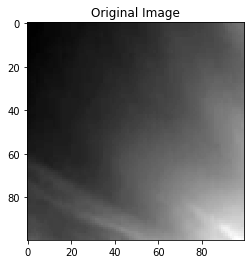

[[ -81.00694   -53.998974  -71.22094  ...  281.3185    366.75586
  -143.26642 ]]


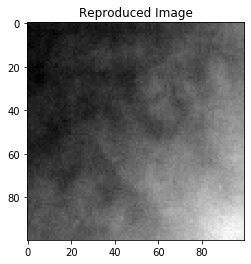

In [13]:
#Testing the model
img=cv2.imread('D:/GraphicalPasswordProject/images/Part-1.jpg',cv2.IMREAD_GRAYSCALE)
img=cv2.resize(img,(IMG_SIZE,IMG_SIZE))
plt.imshow(img,cmap='gray')
plt.title('Original Image')
plt.show()
input_img=np.reshape(img,(1,IMG_SIZE*IMG_SIZE))
compressed_output=compressor.predict(input_img)
print(compressed_output)
final_output=expandor.predict(compressed_output)
output_img=np.reshape(final_output,(IMG_SIZE,IMG_SIZE))
plt.imshow(output_img,cmap='gray')
plt.title('Reproduced Image')
plt.show()

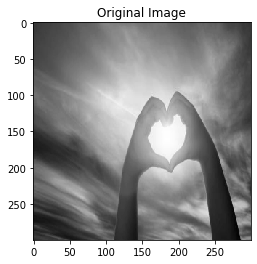

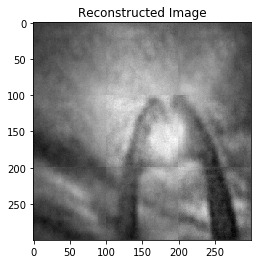

In [16]:
#Recombining the parts of the original image after compression
import math
PATH='D:/GraphicalPasswordProject/images'
num_parts=9
rows=(int)(math.sqrt(num_parts))
columns=rows
recombined=np.zeros([IMG_SIZE*rows,IMG_SIZE*columns])
curr_row=0
curr_column=0
for part in os.listdir(PATH):
    curr_img_path=os.path.join(PATH,part)
    curr_img=cv2.imread(curr_img_path,0)
    curr_img=cv2.resize(curr_img,(IMG_SIZE,IMG_SIZE))
    input_img=np.reshape(curr_img,(1,IMG_SIZE*IMG_SIZE))
    compressed_output=compressor.predict(input_img)
    final_output=expandor.predict(compressed_output)
    final_output=np.reshape(final_output,(IMG_SIZE,IMG_SIZE))
    recombined[curr_row*IMG_SIZE:(curr_row+1)*IMG_SIZE,curr_column*IMG_SIZE:(curr_column+1)*IMG_SIZE]=final_output
    curr_column=curr_column+1
    if (curr_column>=columns):
        curr_column=0
        curr_row=curr_row+1
orig_img=cv2.imread('D:/GraphicalPassWordProject/testinput/test.jpg',0)
orig_img=cv2.resize(orig_img,(300,300))
plt.imshow(orig_img,cmap='gray')
plt.title('Original Image')
plt.show()
plt.imshow(recombined,cmap='gray')
plt.title('Reconstructed Image')
plt.show()